# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Цель исследования — построить модель для определения стоимости.

Данные получим из файла autos.csv.

Исследование пройдёт в четыре этапа:

* Загрузка данных
* Изучение данных
* Обучение моделей
* Анализ моделей

## Загрузка данных

In [1]:
# Установка необходимых библиотек


! pip install phik

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Импорт необходимых библиотек


import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Константы


r_state = 12345

In [4]:
# Функции и классы


# Функция для получения общих сведений о данных

def data_info(title, data):
    
    print('Общие сведения "{}":'.format(title))
    print()
    
    data.info()
    
    print()
    print()
    
    print('Пример данных (случайные 5 строк):')
    display(data.sample(5, random_state=r_state))

    print()
    print()
    
    print('Количество пропусков по столбцам:')
    print()
    for col in data.columns:
        nmv = data[col].isna().sum()
        pmv = nmv/len(data)
        
        if pmv == 0:
            print('\033[0m{} - {} шт. - {:.2%}'.format(col, nmv, pmv))
        elif pmv <= 0.1:
            print('\033[0m{} - \033[43m{} шт.\033[0m - \033[43m{:.2%}'.format(col, nmv, pmv))
        else:
            print('\033[0m{} - \033[41m{} шт.\033[0m - \033[41m{:.2%}'.format(col, nmv, pmv))
        print('\033[0m')
    
    print()
    
    print('Количество уникальных значений в столбцах:')
    print()
    for col in data.columns:
        print('{} - {}'.format(col, data[col].nunique()))
        
    print()
    print()
    
    print('Количество явных дубликатов: {} шт.'.format(data.duplicated().sum()))
    
# Функция для поиска неявных текстовых дубликатов

def check_text(data, col):
    
    checked = set()
    for s in data[col].unique():
        name = s.split(' ')[-1]
        if name != '' and not name in checked:
            checked.add(name)
            ss = data[data[col].str.contains(name)][col].unique()
            if len(ss)>1:
                print(ss)
    
# Функция для корреляции признаков

def corr_info(data, col_del, target):
    
    print('Корреляция признаков:')
    print()
    corr_matrix = data.drop(columns=col_del).corr()
    target_corr = corr_matrix.loc[[target],:]
    sns.set(font_scale=1.15)
    plt.figure(figsize=(8,4))
    sns.heatmap(
                target_corr,
                square=True,
                cmap='RdBu_r',
                annot=True,
                vmin=-1, vmax=1);
    plt.show()
    print()
    for i in range(len(target_corr.columns)):
        if target_corr.columns[i] != target:
            cor = target_corr.loc[target, target_corr.columns[i]]
            print('Корреляция между {} и {}:'.format(target, target_corr.columns[i]))
            if cor == 0:
                print(f'Коэффициент корреляции: {cor:.6f} \n Свзяь отсутствует')
            elif 0 < cor <= 0.3:
                print(f'Коэффициент корреляции: {cor:.6f} \n Слабая прямая связь')
            elif -0.3 <= cor < 0:
                print(f'Коэффициент корреляции: {cor:.6f} \n Слабая обратная связь')
            elif 0.3 < cor <= 0.7:
                print(f'Коэффициент корреляции: {cor:.6f} \n Средняя прямая связь')
            elif -0.7 <= cor < -0.3:
                print(f'Коэффициент корреляции: {cor:.6f} \n Средняя обратная связь')
            elif 0.7 < cor < 1:
                print(f'Коэффициент корреляции: {cor:.6f} \n Сильная прямая связь')
            elif -1 < cor < -0.7:
                print(f'Коэффициент корреляции: {cor:.6f} \n Сильная обратная связь')
            elif cor == 1:
                print(f'Коэффициент корреляции: {cor:.6f} \n Полная прямая связь')
            elif cor == -1:
                print(f'Коэффициент корреляции: {cor:.6f} \n Полная обратная связь')
            else:
                print('Введен неверный коэффициент')
            print()
            
# Функция глобальной корреляции (коэффициент корреляции Phik ( 𝜙 k))

def global_phik(interval_cols):
    
    global_correlation, global_labels = data.global_phik(interval_cols=interval_cols)

    plot_correlation_matrix(global_correlation,
                            x_labels=[''], y_labels=global_labels, 
                            vmin=0, vmax=1, figsize=(3.5,4),
                            color_map="RdBu_r", title=r"$g_k$",
                            fontsize_factor=1.5)
    plt.tight_layout()

# Функция для отделения целевого признака и создания списков численых и категориальных признаков

def split_target(data, target):
    
    features = data.drop([target] , axis=1)
    target = data[target]
    
    categorical_mask = features.dtypes==object
    numeric_mask = features.dtypes!=object
    categorical_cols = features.columns[categorical_mask].tolist()
    numeric_cols = features.columns[numeric_mask].tolist()
    print('Категориальные признаки:', categorical_cols)
    print('Численые признаки:', numeric_cols)
    
    return features, target, categorical_cols, numeric_cols

# Функция разбивки данных для обучения

def split_data(features, target, valid_size, test_size):
    
    if valid_size == 0:
        
        features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=test_size, random_state=r_state)
    
        features_list = {'features_train' : features_train, 'features_test' : features_test}
        targets_list = {'target_train' : target_train, 'target_test' : target_test}

        print('Вспомогательные признаки:')
        print()
        for i in features_list:
            sh = features_list[i].shape
            psh = sh[0]/len(data)
            print('{} - Объектов: {} шт., признаков: {} шт. - {:.2%}'.format(i, sh[0], sh[1], psh))
    
        print()

        print('Целевые признаки:')
        print()
        for i in targets_list:
            sh = targets_list[i].shape
            psh = sh[0]/len(data)
            print('{} - Объектов: {} шт. - {:.2%}'.format(i, sh[0], psh))
    
        return features_train, features_test, target_train, target_test

    else:
        
        valid_test_size = valid_size + test_size
        t_size = test_size / valid_test_size
        
        features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=valid_test_size, random_state=r_state)
        
        features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid, target_valid, test_size=t_size, random_state=r_state)
    
        features_list = {'features_train' : features_train, 
                         'features_valid' : features_valid, 
                         'features_test' : features_test}
        targets_list = {'target_train' : target_train,
                        'target_valid' : target_valid, 
                        'target_test' : target_test}

        print('Вспомогательные признаки:')
        print()
        for i in features_list:
            sh = features_list[i].shape
            psh = sh[0]/len(data)
            print('{} - Объектов: {} шт., признаков: {} шт. - {:.2%}'.format(i, sh[0], sh[1], psh))
    
        print()

        print('Целевые признаки:')
        print()
        for i in targets_list:
            sh = targets_list[i].shape
            psh = sh[0]/len(data)
            print('{} - Объектов: {} шт. - {:.2%}'.format(i, sh[0], psh))
    
        return features_train, features_valid, features_test, target_train, target_valid, target_test

# Функция для подсчета RMSE

def rmse(target, predicted):
    return mse(target, predicted) ** 0.5

# Класс для сохранения статистики обучения моделей (время обучения, время предсказания и RMSE)

class ModelStat:
    
    def __init__(self, name, model):
        self.name = name
        self.model = model
    
    def fit(self, features, target):
        start_time = time.time()    
        self.model.fit(features, target)
        end_time = time.time() - start_time
        self.fit_time = end_time
    
    def predict(self, features, target):
        start_time = time.time()  
        predicted = self.model.predict(features)
        end_time = time.time() - start_time
        self.predict_time = end_time
        self.rmse = rmse(target, predicted)
        
    def getResult(self):
        return self.name, round(self.fit_time, 3), round(self.predict_time, 3), round(self.rmse, 5)

In [5]:
data = pd.read_csv('datasets/autos.csv')

## Изучение данных

### Первичный анализ

In [6]:
data_info('data', data)

Общие сведения "data":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
d

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
18734,2016-04-04 13:36:58,16900,bus,2010,auto,150,viano,150000,4,gasoline,mercedes_benz,no,2016-04-04 00:00:00,0,60326,2016-04-05 12:18:31
141787,2016-03-07 17:57:08,15500,other,2011,manual,143,1er,40000,5,gasoline,bmw,no,2016-03-07 00:00:00,0,35083,2016-04-06 20:19:15
37523,2016-03-24 09:37:02,3600,sedan,2004,manual,125,astra,150000,12,petrol,opel,no,2016-03-24 00:00:00,0,13627,2016-03-24 10:38:57
194192,2016-03-15 09:49:03,8990,sedan,2007,auto,224,c_klasse,150000,9,gasoline,mercedes_benz,no,2016-03-15 00:00:00,0,58135,2016-03-18 02:17:06
110210,2016-03-29 23:43:52,2500,other,1994,manual,68,transporter,150000,9,gasoline,volkswagen,no,2016-03-29 00:00:00,0,24598,2016-04-02 12:45:46




Количество пропусков по столбцам:

DateCrawled - 0 шт. - 0.00%

Price - 0 шт. - 0.00%

VehicleType - 37490 шт. - 10.58%

RegistrationYear - 0 шт. - 0.00%

Gearbox - 19833 шт. - 5.60%

Power - 0 шт. - 0.00%

Model - 19705 шт. - 5.56%

Kilometer - 0 шт. - 0.00%

RegistrationMonth - 0 шт. - 0.00%

FuelType - 32895 шт. - 9.28%

Brand - 0 шт. - 0.00%

Repaired - 71154 шт. - 20.08%

DateCreated - 0 шт. - 0.00%

NumberOfPictures - 0 шт. - 0.00%

PostalCode - 0 шт. - 0.00%

LastSeen - 0 шт. - 0.00%


Количество уникальных значений в столбцах:

DateCrawled - 271174
Price - 3731
VehicleType - 8
RegistrationYear - 151
Gearbox - 2
Power - 712
Model - 250
Kilometer - 13
RegistrationMonth - 13
FuelType - 7
Brand - 40
Repaired - 2
DateCreated - 109
NumberOfPictures - 1
PostalCode - 8143
LastSeen - 179150


Количество явных дубликатов: 4 шт.


Описание данных:

* Данные состоят из 354369 объектов
* Имееют 16 признаков:
    * Вспомогательные признаки:
        * DateCrawled — дата скачивания анкеты из базы
        * VehicleType — тип автомобильного кузова
        * RegistrationYear — год регистрации автомобиля
        * Gearbox — тип коробки передач
        * Power — мощность (л. с.)
        * Model — модель автомобиля
        * Kilometer — пробег (км)
        * RegistrationMonth — месяц регистрации автомобиля
        * FuelType — тип топлива
        * Brand — марка автомобиля
        * Repaired — была машина в ремонте или нет
        * DateCreated — дата создания анкеты
        * NumberOfPictures — количество фотографий автомобиля
        * PostalCode — почтовый индекс владельца анкеты (пользователя)
        * LastSeen — дата последней активности пользователя
    * Целевой признак:
        * Price — цена (евро)
* Присутствуют признаки, не влияющие на целевой признак (удалим их):
    * DateCrawled — дата скачивания анкеты из базы
    * RegistrationMonth — месяц регистрации автомобиля
    * DateCreated — дата создания анкеты
    * NumberOfPictures — количество фотографий автомобиля
    * PostalCode — почтовый индекс владельца анкеты (пользователя)
    * LastSeen — дата последней активности пользователя
* Присутствуют пропуски:
    * VehicleType - 37490 шт. - 10.58%
    * Gearbox - 19833 шт. - 5.60%
    * Model - 19705 шт. - 5.56%
    * FuelType - 32895 шт. - 9.28%
    * Repaired - 71154 шт. - 20.08%
* Содержат 4 явных дубликата
* Изучим подробнее признаки и проверим на наличие аномалий:
    * Price — цена (евро)
    * RegistrationYear — год регистрации автомобиля
    * VehicleType — тип автомобильного кузова
    * Gearbox — тип коробки передач
    * Power — мощность (л. с.)
    * Model — модель автомобиля
    * Kilometer — пробег (км)
    * FuelType — тип топлива
    * Brand — марка автомобиля
    * Repaired — была машина в ремонте или нет

### Предобработка данных

#### Удалим признаки, не влияющие на целевой признак

In [7]:
data.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'],
           axis=1,
           inplace=True)
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

#### Проверка на наличие аномалий и пропусков

##### Признак "Price" 

In [8]:
print("Минимальная цена:", data['Price'].min())
print("Максимальная цена:", data['Price'].max())
print("Количество нулевых значений:", len(data[data['Price']==0]))

Минимальная цена: 0
Максимальная цена: 20000
Количество нулевых значений: 10772


Цена не может быть равна нулю. Удалим нулевые значения

In [9]:
data = data[data['Price'] != 0]
print("Количество нулевых значений:", len(data[data['Price']==0]))

Количество нулевых значений: 0


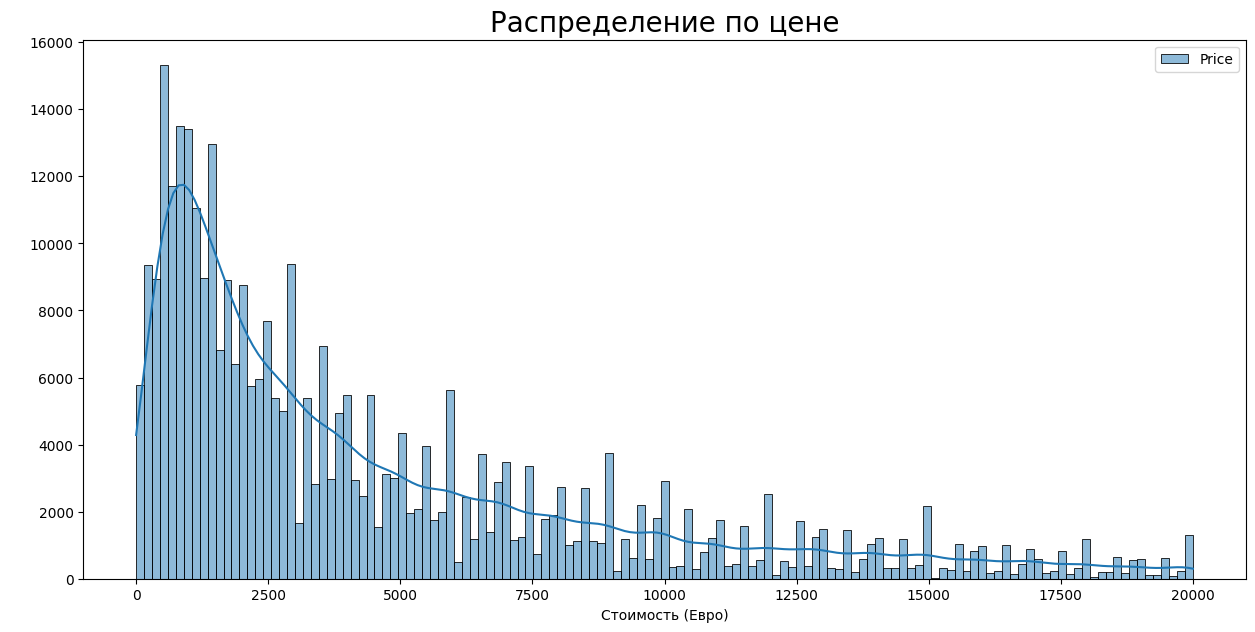

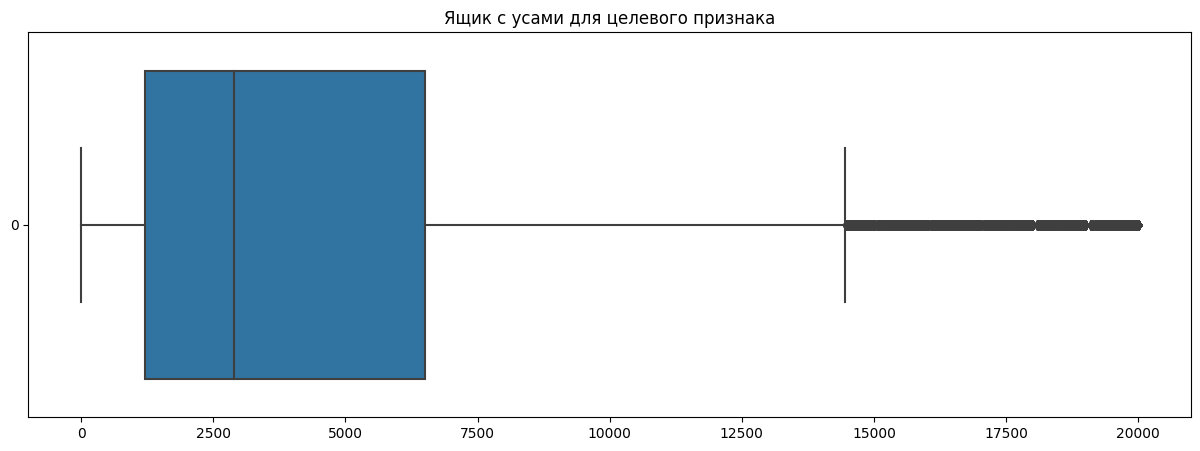

In [10]:
x = data['Price']
plt.figure(figsize=(15,7))
sns.histplot(x, label="Price", kde=True);
plt.legend();
plt.title(label='Распределение по цене', fontsize=20)
plt.xlabel('Стоимость (Евро)')
plt.ylabel(' ')
plt.show()

plt.figure(figsize=(15,5))
sns.boxplot(data=data['Price'], orient='h')
plt.title('Ящик с усами для целевого признака')
plt.show()


На гистограме много околонулевых значений и есть выбросы после 15000
Посмотрим значения 5% квантилей

In [11]:
data['Price'].quantile([.05, 0.95])

0.05      350.0
0.95    14800.0
Name: Price, dtype: float64

Проверим долю значений меньше 350 и больше 14800

In [12]:
print('{:.2%}'.format(1 - data.query('350 <= Price <= 14800').shape[0] / data.shape[0]))

9.52%


Удалим все значения меньше 350 и больше 14800

In [13]:
data = data.query('350 <= Price <= 14800')
print("Минимальная цена:", data['Price'].min())
print("Максимальная цена:", data['Price'].max())

Минимальная цена: 350
Максимальная цена: 14800


##### Признак "RegistrationYear" 

In [14]:
data['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1300, 1400, 1500, 1600, 1602, 1800,
       1910, 1923, 1925, 1928, 1929, 1930, 1931, 1932, 1934, 1935, 1936,
       1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1948, 1949,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2066, 2290, 2500, 2800, 2900, 3000, 3200,
       3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5911, 6000,
       7000, 7100, 7800, 8200, 8500, 8888, 9000, 9450, 9999], dtype=int64)

* Присутствуют аномальные значения
* Автомобили до 1950 считаются раритетными и не важны для нашего исследованния ввиду своей редкости. Возьмем 1950 за минимальный год.
* Проверим самую позднюю дату скачивания анкеты из базы, год регистрации не может быть позднее этой даты.


In [15]:
min_year = 1950
max_year = pd.to_datetime(pd.read_csv('datasets/autos.csv')['DateCrawled'].max()).year
print("Минимальный год регистрации:", min_year)
print("Максимальный год регистрации:", max_year)
data = data.query('@min_year <= RegistrationYear <= @max_year')
data['RegistrationYear'].sort_values().unique()

Минимальный год регистрации: 1950
Максимальный год регистрации: 2016


array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016], dtype=int64)

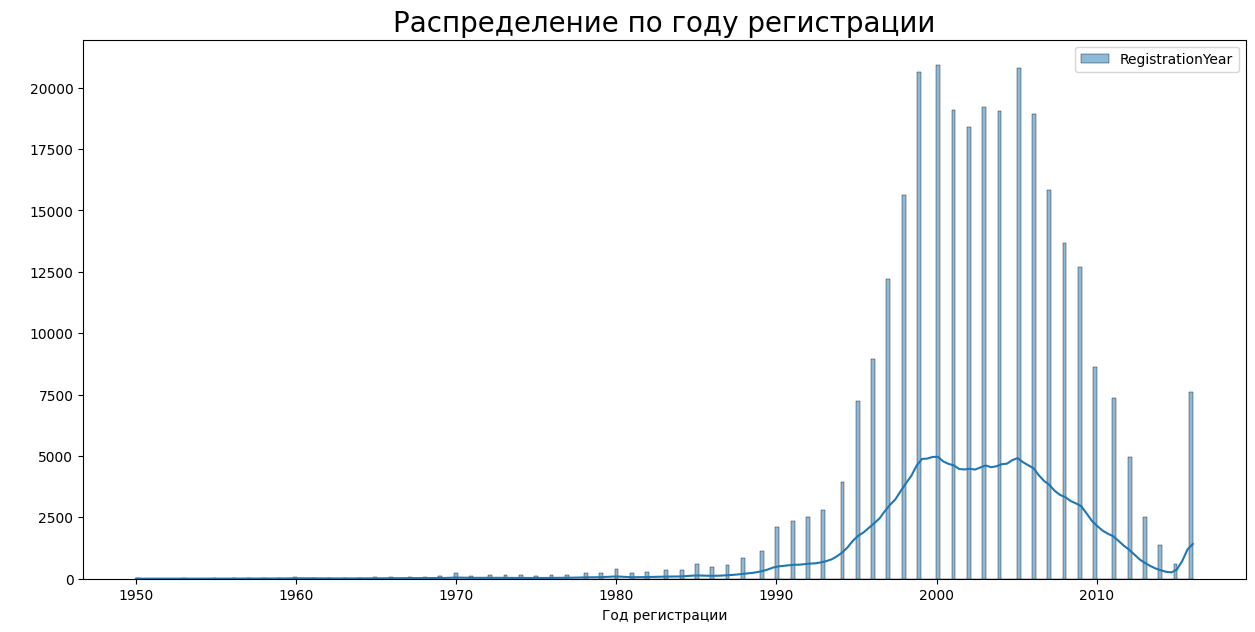

In [16]:
x = data['RegistrationYear']
plt.figure(figsize=(15,7))
sns.histplot(x, label="RegistrationYear", kde=True);
plt.legend();
plt.title(label='Распределение по году регистрации', fontsize=20)
plt.xlabel('Год регистрации')
plt.ylabel(' ')
plt.show()

##### Признак "VehicleType" 

Заменим пропуски заглушкой "unknown"

In [17]:
data.fillna({'VehicleType':'unknown'}, inplace=True)
print('Количество пропущеных значений:', data['VehicleType'].isna().sum())
data['VehicleType'].value_counts()

Количество пропущеных значений: 0


sedan          82523
small          71279
wagon          58776
bus            26477
convertible    17519
unknown        15530
coupe          13326
suv             9475
other           2781
Name: VehicleType, dtype: int64

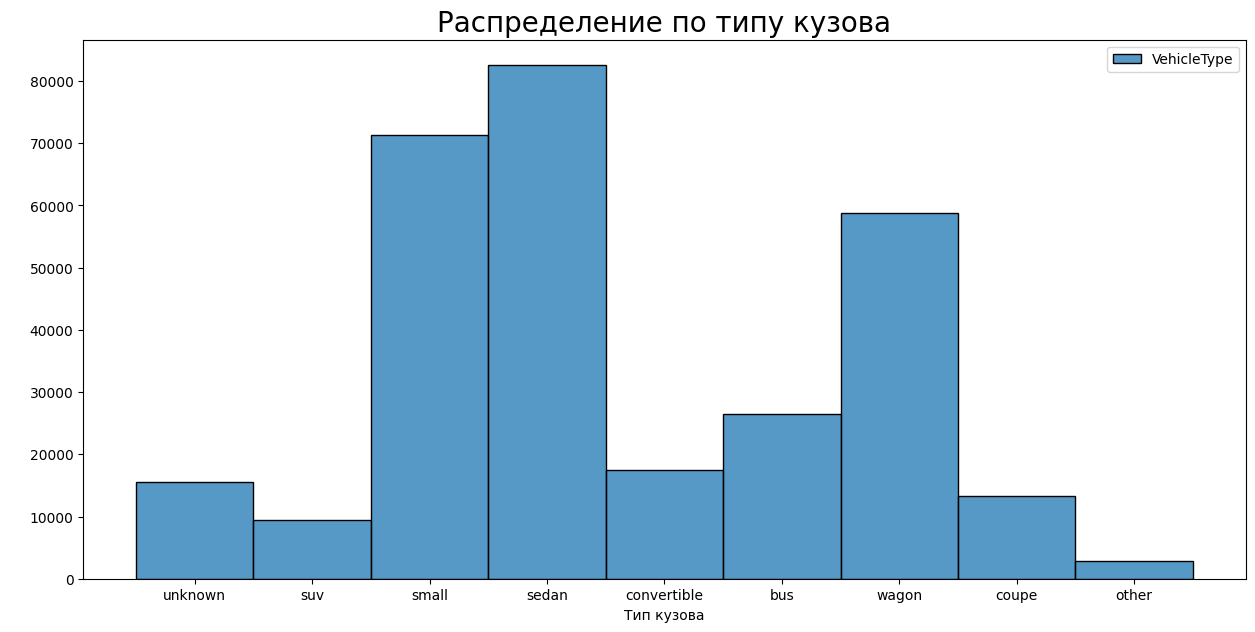

In [18]:
x = data['VehicleType']
plt.figure(figsize=(15,7))
sns.histplot(x, label="VehicleType");
plt.legend();
plt.title(label='Распределение по типу кузова', fontsize=20)
plt.xlabel('Тип кузова')
plt.ylabel(' ')
plt.show()

##### Признак "Gearbox" 

In [19]:
print('Количество пропущеных значений:', data['Gearbox'].isna().sum())

Количество пропущеных значений: 12480


Признак "Gearbox" весомый параметр, который может повлиять на обучение модели. Заменить пропуски на адекватные значения с учетом других признаков невозможно. Удалим все объекты с пропусками в  данном признаке.

In [20]:
data.dropna(subset=['Gearbox'], inplace=True)

In [21]:
print('Количество пропущеных значений:', data['Gearbox'].isna().sum())

Количество пропущеных значений: 0


##### Признак "Power" 

In [22]:
data['Power'].describe()

count    285206.000000
mean        113.872320
std         186.882395
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [23]:
print('Количество объектов с заявленной мощностью больше 350 л. с.:', data[data['Power'] > 350]['Price'].count())

Количество объектов с заявленной мощностью больше 350 л. с.: 651


* На 2016 год среди серийных автомобилей:
    * Самая максимальная мощность - 1500 л. с.
    * Самая минимальная мощность - 9 л. с.
* Объектов с заявленной мощностью больше 350 л. с. небольшое количество
* Оставим значения в пределах от 9 до 350 л. с.

In [24]:
min_power = 9
max_power = 350
data = data.query('@min_power <= Power <= @max_power')

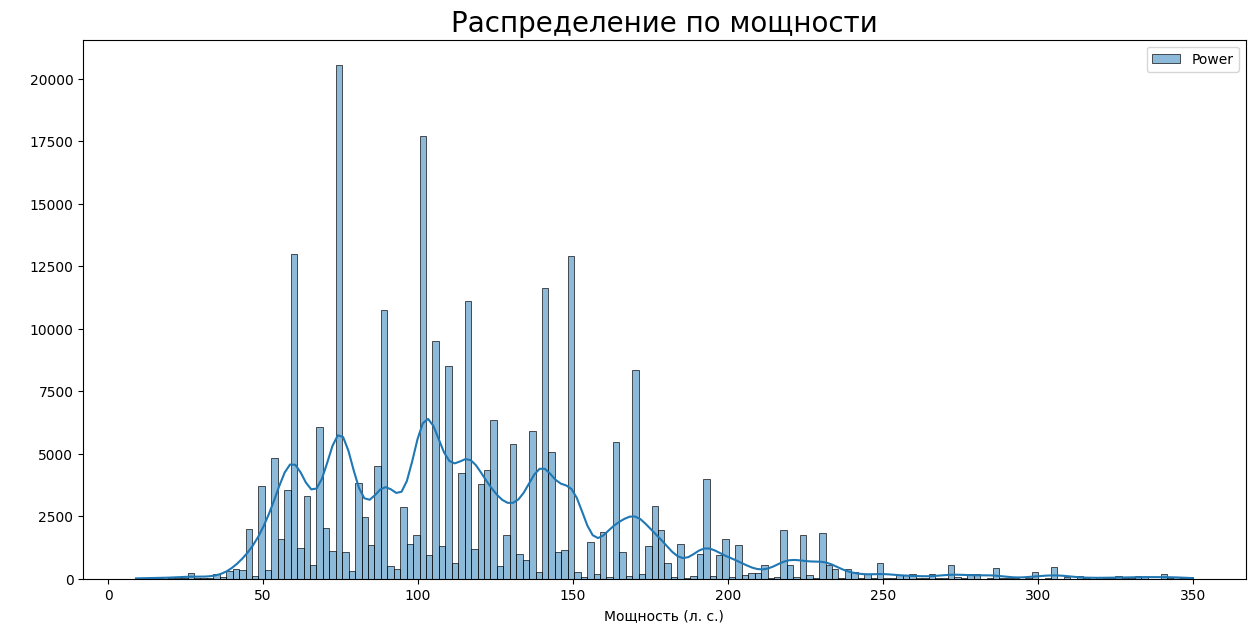

In [25]:
x = data['Power']
plt.figure(figsize=(15,7))
sns.histplot(x, label="Power", kde=True);
plt.legend();
plt.title(label='Распределение по мощности', fontsize=20)
plt.xlabel('Мощность (л. с.)')
plt.ylabel(' ')
plt.show()

##### Признак "Model" 

In [26]:
print('Количество пропущеных значений:', data['Model'].isna().sum())

Количество пропущеных значений: 9155


Признак "Model" весомый параметр, который может повлиять на обучение модели. Заменить пропуски на адекватные значения с учетом других признаков невозможно. Удалим все объекты с пропусками в  данном признаке.

In [27]:
data.dropna(subset=['Model'], inplace=True)

In [28]:
print('Количество пропущеных значений:', data['Model'].isna().sum())

Количество пропущеных значений: 0


Проверим на наличие неявных дубликатов

In [29]:
check_text(data, 'Model')

['kadett' 'jetta' 'tt']
['kadett' 'ka' 'kangoo' 'kaefer' 'kalos' 'kalina' 'kappa']
['lupo' 'up' 'superb']
['rio' 'sirion' 'terios']
['slk' 'sl']
['rx_reihe' 'x_reihe' 'mx_reihe' 'cx_reihe']
['rav' 'bravo']
['90' '900' '9000']
['xc_reihe' 'c_reihe']
['scirocco' 'accord' 'cc']
['clio' 'clk' 'cl' 'clubman']
['900' '9000']
['carnival' 'niva']
['range_rover_sport' 'range_rover' 'range_rover_evoque']
['wrangler' 'glk' 'gl']


Неявные дубликаты отсутствуют

##### Признак "Kilometer" 

In [30]:
data['Kilometer'].value_counts()

150000    173879
125000     27875
100000     10949
90000       8702
80000       7464
70000       6291
60000       5403
50000       4313
40000       3317
30000       2804
20000       2184
5000        1939
10000        567
Name: Kilometer, dtype: int64

* Пропуски отсутствуют
* Аномалий не обнаружено

##### Признак "FuelType" 

Заменим пропуски заглушкой "unknown"

In [31]:
data.fillna({'FuelType':'unknown'}, inplace=True)
print('Количество пропущеных значений:', data['FuelType'].isna().sum())
data['FuelType'].value_counts()

Количество пропущеных значений: 0


petrol      164347
gasoline     76043
unknown      10378
lpg           4228
cng            449
hybrid         139
other           61
electric        42
Name: FuelType, dtype: int64

##### Признак "Brand" 

Проверим на наличие неявных дубликатов

In [32]:
check_text(data, 'Brand')

['rover' 'land_rover']


Неявные дубликаты отсутствуют

##### Признак "Repaired" 

In [33]:
print('Количество пропущеных значений:', data['Repaired'].isna().sum())

Количество пропущеных значений: 33397


Признак "Repaired" весомый параметр, который может повлиять на обучение модели. Заменить пропуски на адекватные значения с учетом других признаков невозможно. Так как пропущенных значений больше количество, заменим пропуски заглушкой "unknown".

In [34]:
data.fillna({'Repaired':'unknown'}, inplace=True)
print('Количество пропущеных значений:', data['Repaired'].isna().sum())
data['Repaired'].value_counts()

Количество пропущеных значений: 0


no         198958
unknown     33397
yes         23332
Name: Repaired, dtype: int64

#### Проверка корреляции целевого признака

##### Корреляция числовых признаков

Корреляция признаков:



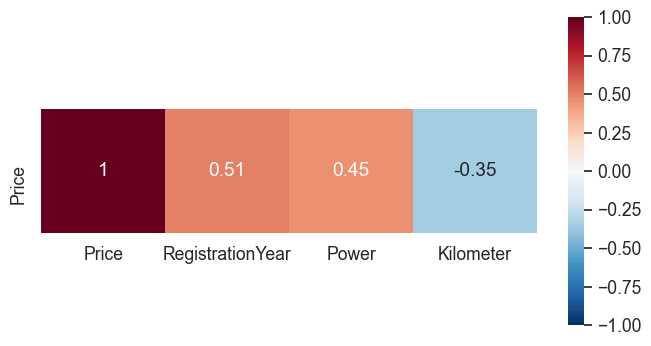


Корреляция между Price и RegistrationYear:
Коэффициент корреляции: 0.507223 
 Средняя прямая связь

Корреляция между Price и Power:
Коэффициент корреляции: 0.454259 
 Средняя прямая связь

Корреляция между Price и Kilometer:
Коэффициент корреляции: -0.346303 
 Средняя обратная связь



In [35]:
col_del = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
corr_info(data, col_del, 'Price')

##### Глобальная корреляция (коэффициент корреляции Phik ( 𝜙 k))

Глобальный коэффициент корреляции — полезная мера, выражающая общую корреляцию одной переменной со всеми другими переменными в наборе данных. Это дает нам представление о том, насколько хорошо одна переменная может быть смоделирована с использованием других переменных.

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\phik\phik.py:319: RuntimeWarning: invalid value encountered in sqrt
  global_correlations = np.sqrt(


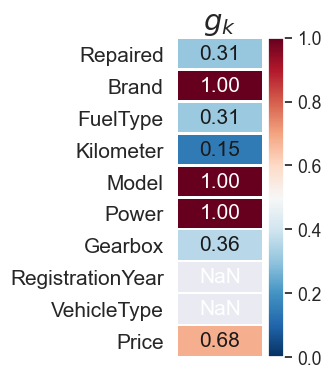

In [36]:
interval_cols = ['Price']
global_phik(interval_cols)

Глобальная корреляция целевого признака достаточно высока, можем приступить к обучению моделей

## Обучение моделей

### Отделим целевой признак и создадим списки численых и категориальных признаков

In [37]:
features, target, categorical_cols, numeric_cols = split_target(data, 'Price')

Категориальные признаки: ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
Численые признаки: ['RegistrationYear', 'Power', 'Kilometer']


### Разобьем данные на обучающую, валидационную и тестовую выборки в соотношении 60:20:20

In [38]:
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target, 0.2, 0.2)

Вспомогательные признаки:

features_train - Объектов: 153412 шт., признаков: 9 шт. - 60.00%
features_valid - Объектов: 51137 шт., признаков: 9 шт. - 20.00%
features_test - Объектов: 51138 шт., признаков: 9 шт. - 20.00%

Целевые признаки:

target_train - Объектов: 153412 шт. - 60.00%
target_valid - Объектов: 51137 шт. - 20.00%
target_test - Объектов: 51138 шт. - 20.00%


### Подготовим категориальные признаки

Для линейных моделей техникой OHE:

In [39]:
features_train_ohe = pd.get_dummies(features_train, columns=categorical_cols, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, columns=categorical_cols, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, columns=categorical_cols, drop_first=True)

common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]

Для моделей, основанных на деревьях решений порядковым кодированием (OrdinalEncoder)

In [40]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
encoder.fit(features_train[categorical_cols])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[categorical_cols] = encoder.transform(features_train_ord[categorical_cols])
features_valid_ord[categorical_cols] = encoder.transform(features_valid_ord[categorical_cols])
features_test_ord[categorical_cols] = encoder.transform(features_test_ord[categorical_cols])

### Стандартизируем численные признаки в выборках, так как в данных присутствуют значения в разных масштабах

In [41]:
scaler = StandardScaler()
scaler.fit(features_train[numeric_cols])

features_train_ohe[numeric_cols] = scaler.transform(features_train_ohe[numeric_cols])
features_valid_ohe[numeric_cols] = scaler.transform(features_valid_ohe[numeric_cols])
features_test_ohe[numeric_cols] = scaler.transform(features_test_ohe[numeric_cols])

features_train_ord[numeric_cols] = scaler.transform(features_train_ord[numeric_cols])
features_valid_ord[numeric_cols] = scaler.transform(features_valid_ord[numeric_cols])
features_test_ord[numeric_cols] = scaler.transform(features_test_ord[numeric_cols])

### Обучим модели

#### Создадим переменную для хранения статистики

In [42]:
stat = []

#### Random Forest Regressor

Найдем лучшие параметры для модели

In [43]:
forest = RandomForestRegressor()
forest_params = {'n_estimators': range(5,50,10),
              'max_depth': range(1,21,5), 
              'min_samples_leaf': range(2,6,2), 
              'min_samples_split': range(2,6,2)}


grid_forest = GridSearchCV(forest, forest_params, cv=3, scoring='neg_mean_squared_error')
grid_forest.fit(features_train_ord, target_train)

grid_forest.best_params_

# {'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 45}

{'max_depth': 16,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 45}

Обучим модель и сохраним статистику

In [44]:
model_forest = grid_forest.best_estimator_
model_forest_stat = ModelStat('Random forest', model_forest)
model_forest_stat.fit(features_train_ord, target_train)
model_forest_stat.predict(features_valid_ord, target_valid)
stat.append(model_forest_stat.getResult())

#### Linear Regression

Обучим модель и сохраним статистику

In [45]:
model_lr = LinearRegression()
model_lr_stat = ModelStat('Linear regression', model_lr)
model_lr_stat.fit(features_train_ohe, target_train)
model_lr_stat.predict(features_valid_ohe, target_valid)
stat.append(model_lr_stat.getResult())

#### LGBM Regressor

Найдем лучшие параметры для модели

In [46]:
gbm = LGBMRegressor(boosting_type='gbdt', verbose=0, seed=r_state)
gbm_params = {'learning_rate':[x/10 for x in range(1, 11)], 
              'n_estimators': range(20, 61, 20), 
              'num_leaves': range(20, 41, 10)}

grid_gbm = GridSearchCV(gbm, gbm_params, cv=3, scoring='neg_mean_squared_error')
grid_gbm.fit(features_train_ord, target_train);

grid_gbm.best_params_

#{'learning_rate': 0.4, 'n_estimators': 60, 'num_leaves': 40}

{'learning_rate': 0.4, 'n_estimators': 60, 'num_leaves': 40}

Обучим модель и сохраним статистику

In [47]:
model_gbm = grid_gbm.best_estimator_
model_gbm_stat = ModelStat('LightGBM', model_gbm)
model_gbm_stat.fit(features_train_ord, target_train)
model_gbm_stat.predict(features_valid_ord, target_valid)
stat.append(model_gbm_stat.getResult())

#### CatBoost Regressor

Найдем лучшие параметры для модели

In [48]:
cbr = CatBoostRegressor(loss_function='RMSE',silent=True, random_seed=r_state)
cbr_params = {'learning_rate': np.logspace(-3, 0, 5),
              'iterations': range(20, 60, 20),
              'depth': range(5,10,2)}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=3, scoring='neg_mean_squared_error')
grid_cbr.fit(features_train_ord, target_train);

grid_cbr.best_params_

# {'depth': 9, 'iterations': 40, 'learning_rate': 1.0}

{'depth': 9, 'iterations': 40, 'learning_rate': 1.0}

Обучим модель и сохраним статистику

In [49]:
model_cbr = grid_cbr.best_estimator_
model_cbr_stat = ModelStat('CatBoost', model_cbr)
model_cbr_stat.fit(features_train_ord, target_train)
model_cbr_stat.predict(features_valid_ord, target_valid)
stat.append(model_cbr_stat.getResult())

#### CatBoost Regressor без предобработки данных методом OHE

Так как модель CatBoost самостоятельно обрабатывает категориальные признаки, попробуем применить данную модель на данных без предобработки методом OHE 

Подготовим данные

In [50]:
features_train_cb = features_train.copy()
features_valid_cb = features_valid.copy()
features_test_cb = features_test.copy()

features_train_cb[numeric_cols] = scaler.transform(features_train_cb[numeric_cols])
features_valid_cb[numeric_cols] = scaler.transform(features_valid_cb[numeric_cols])
features_test_cb[numeric_cols] = scaler.transform(features_test_cb[numeric_cols])

Найдем лучшие параметры для модели

In [51]:
cbr_no_ohe = CatBoostRegressor(loss_function='RMSE',silent=True, cat_features=categorical_cols, random_seed=r_state)
cbr_no_ohe_params = {'learning_rate': np.logspace(-3, 0, 5),'iterations': range(20, 60, 20),'depth': range(5,10,2)}

grid_cbr_no_ohe = GridSearchCV(cbr_no_ohe, cbr_no_ohe_params, cv=3, scoring='neg_mean_squared_error')
grid_cbr_no_ohe.fit(features_train_cb, target_train);

grid_cbr_no_ohe.best_params_

#{'depth': 9, 'iterations': 40, 'learning_rate': 1.0}

{'depth': 9, 'iterations': 40, 'learning_rate': 1.0}

Обучим модель и сохраним статистику

In [52]:
model_cbr_no_ohe = grid_cbr_no_ohe.best_estimator_
model_cbr_no_ohe_stat = ModelStat('CatBoost_no_ohe', model_cbr_no_ohe)
model_cbr_no_ohe_stat.fit(features_train_cb, target_train)
model_cbr_no_ohe_stat.predict(features_valid_cb, target_valid)
stat.append(model_cbr_no_ohe_stat.getResult())

## Анализ моделей

Создадим DataFrame со статистическими данными наших моделей

In [53]:
stat_df = pd.DataFrame(stat, columns =['Модель', 'Время обучения', 'Время предсказания', 'RMSE'])
stat_df.sort_values(by='RMSE')

,Модель,Время обучения,Время предсказания,RMSE
0,Random forest,46.264,0.986,1341.20856
2,LightGBM,2.494,0.420,1355.59694
3,CatBoost,6.613,0.072,1380.62530
4,CatBoost_no_ohe,22.884,0.380,1386.19893
1,Linear regression,14.735,0.343,2054.58365


Создадим колонку с рейтингом и запишем туда данные на основе "формулы рейтинга"

In [54]:
# 'Формула рейтинга' придумана мной для оценки лучшей модели с учетом критериев заказчика.
# Возможно она не корректна и существует готовая модель или формула, но в данном случае позволяет выявить лучшую модель

stat_df['Рейтинг'] = round((100 - (.34 * stat_df['RMSE'] / stat_df['RMSE'].min() + 
                            .33 * stat_df['Время обучения'] / stat_df['Время обучения'].min() +
                           .33 * stat_df['Время предсказания'] / stat_df['Время предсказания'].min())) / 10, 3)

Посмотрим итоговую таблицу и оценим результат исследрвания

In [55]:
stat_df.sort_values(by='Рейтинг', ascending=False)

,Модель,Время обучения,Время предсказания,RMSE,Рейтинг
3,CatBoost,6.613,0.072,1380.62530,9.844
2,LightGBM,2.494,0.420,1355.59694,9.740
1,Linear regression,14.735,0.343,2054.58365,9.596
4,CatBoost_no_ohe,22.884,0.380,1386.19893,9.488
0,Random forest,46.264,0.986,1341.20856,8.902


## Тестирование лучшей модели

Лучшая модель согласно нашему рейтингу - CatBoost с предварительным кодированием данных.

Проверим ее на тестовой выборке

Объединим обучающую и валидационную выборки для обучения итоговой модели на большем количестве данных

In [56]:
features_ord_final = pd.concat([features_train_ord, features_valid_ord])
target_final = pd.concat([target_train, target_valid])

In [57]:
stat_final = []

In [58]:
model_cbr_stat_final = ModelStat('CatBoost_final', model_cbr)
model_cbr_stat_final.fit(features_ord_final, target_final)
model_cbr_stat_final.predict(features_test_ord, target_test)
stat_final.append(model_cbr_stat_final.getResult())

In [59]:
stat_df_final = pd.DataFrame(stat_final, columns =['Модель', 'Время обучения', 'Время предсказания', 'RMSE'])
stat_df_final.loc[1] = stat[3]
stat_df_final

,Модель,Время обучения,Время предсказания,RMSE
0,CatBoost_final,10.237,0.072,1364.37708
1,CatBoost,6.613,0.072,1380.62530


Финальный тест показал хорошие результаты

* Время обучения немного выросло, но мы объединили обучающую и валидационную выборки для обучения итоговой модели на большем количестве данных
* Время предсказания незначительно изменилось
* Качество предсказаний улучшилось

Можем рекомендовать модель CatBoost

## Общий вывод

Проведено исследование с целью найти лучшую модель для определения стоимости автомобилей

Заказчику были важны:

* качество предсказания
* скорость предсказания
* время обучения


Цель исследования — построить модель для определения стоимости.

Данные получили из файла autos.csv.

Исследование проходило в четыре этапа:

* Загрузка данных
* Изучение данных
* Обучение моделей
* Анализ моделей

Мы использовали модели градиетного бустинга CatBoostRegressor и LightGBM, и сравнили их с базовыми моделями LinearRegression и RandomForestRegressor

Исходя из полученных данных статистики обучения моделей:

* Лучшая модель - CatBoost
    * Результаты на данной модели с предобработкой данных методом OHE и без него - примерно одинаковы
* Модель LightGBM по сравнению с CatBoost незначительно точнее в предсказаниях, но хуже по скорости обучения и предсказания
* Базовые модели значительно отстают от моделей градиентного бустинга либо в качестве, либо по скорости работы

Для компании можем рекомендовать модель CatBoost